SVR Metrics= [0.003655616610636736, 4414.383379286357, 40.081464227157, 6640.446856021106]
DT Metrics= [0.8686615185249379, 1870.6321557120505, 18.106051465483013, 2410.951990079329]
RF Metrics= [0.9367648057215591, 1124.1687949269478, 9.820571082515917, 1672.9077591793027]
GB Metrics= [0.9437051359289245, 1106.8355152929578, 10.1064730043447, 1578.4359157766066]
           R2          MAE       MAPE         RMSE
SVR  0.003656  4414.383379  40.081464  6640.446856
DT   0.868662  1870.632156  18.106051  2410.951990
RF   0.936765  1124.168795   9.820571  1672.907759
GB   0.943705  1106.835515  10.106473  1578.435916
GP   0.909834  1372.563748  13.088755  1997.627919


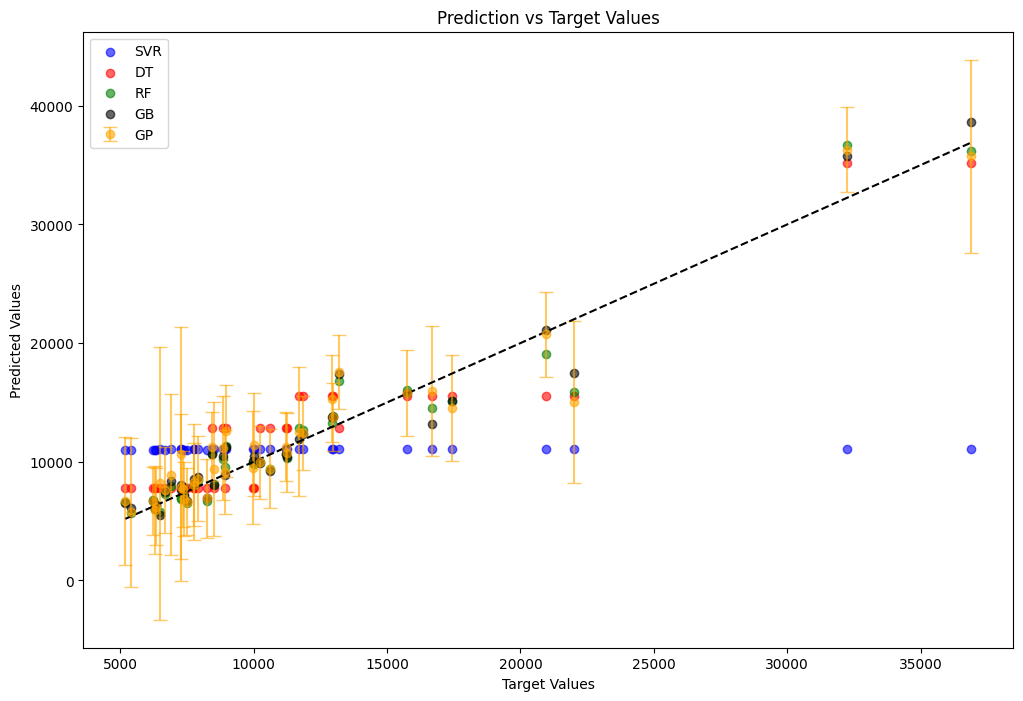

In [6]:
#-----------------------------------------------------------------
#NERS 590: Applied Machine Learning for Nuclear Engineers
#In-class sript: Classical ML demonstration to predict car price
#Date: 7/28/2024
#Author: Majdi I. Radaideh
#-----------------------------------------------------------------

#This script needs sklearn > 1.4 to run
#use the line below for Colab since it has an old sklearn
#!pip install -U scikit-learn==1.4.2

#Basic packages
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import warnings       #Suppress warnings
warnings.filterwarnings("ignore")

#GP tools
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

#other classical regeressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

#metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def root_mean_squared_error(y, yhat):
  return np.sqrt(mean_squared_error(y,yhat))

#--------------------------
# Data loading & Processing
#--------------------------
url='https://raw.githubusercontent.com/aims-umich/ners590data/main/cars.csv'
data=pd.read_csv(url)
data=data.dropna()
npdata=data.values

#assign features and outputs
X=npdata[:,0:8]
Y=npdata[:,-1]

#split the data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1)

#scale the features
xscaler =MinMaxScaler()
Xtrain=xscaler.fit_transform(Xtrain)
Xtest=xscaler.transform(Xtest)

#did not scale Y data since we have a single output

#--------------------------
# Support Vector (SVR)
#--------------------------
#Define, fit svr, and evaluate metrics
svr=SVR(kernel='rbf', C=1.1, epsilon=0.2)
svr.fit(Xtrain,Ytrain)
Ysvr= svr.predict(Xtest)

svr_metrics = [r2_score(Ytest, Ysvr), mean_absolute_error(Ytest,Ysvr),
         mean_absolute_percentage_error(Ytest, Ysvr)*100, root_mean_squared_error(Ytest,Ysvr)]
print('SVR Metrics=', svr_metrics)

#--------------------------
# Decistion Trees (DT)
#--------------------------
#Define, fit DT, and evaluate metrics
dt = DecisionTreeRegressor(max_depth=3, random_state=1)
dt.fit(Xtrain, Ytrain)
Ydt=dt.predict(Xtest)
dt_metrics = [r2_score(Ytest, Ydt), mean_absolute_error(Ytest,Ydt),
         mean_absolute_percentage_error(Ytest, Ydt)*100, root_mean_squared_error(Ytest,Ydt)]
print('DT Metrics=', dt_metrics)

#--------------------------
# Random Forests (RF)
#--------------------------
#Define, fit RF, and evaluate metrics
rf = RandomForestRegressor(n_estimators=200, max_features=8, random_state = 1)
rf.fit(Xtrain, Ytrain)
Yrf=rf.predict(Xtest)
rf_metrics = [r2_score(Ytest, Yrf), mean_absolute_error(Ytest,Yrf),
         mean_absolute_percentage_error(Ytest, Yrf)*100, root_mean_squared_error(Ytest,Yrf)]
print('RF Metrics=', rf_metrics)

#--------------------------
# Gradient Boosting (GB)
#--------------------------
#Define, fit GB, and evaluate metrics
gboost = GradientBoostingRegressor(n_estimators=200, max_features=8, random_state = 1)
gboost.fit(Xtrain, Ytrain)
Ygboost=gboost.predict(Xtest)
gboost_metrics = [r2_score(Ytest, Ygboost), mean_absolute_error(Ytest,Ygboost),
         mean_absolute_percentage_error(Ytest, Ygboost)*100, root_mean_squared_error(Ytest,Ygboost)]
print('GB Metrics=', gboost_metrics)

#--------------------------
# Gaussian Processes (GP)
#--------------------------
#Upon initial tests, we noticed GP needs output scaling to perform well
#Try to remove that and see what happens
yscaler=StandardScaler()
Ytrain_scaled=yscaler.fit_transform(Ytrain.reshape(-1,1)).flatten()

#Kernel parameters
constant_value=1
matern_length_scale=1
nu=1.5
noise_level=1

#Define a composite kernel
k = ConstantKernel(constant_value=constant_value) + \
WhiteKernel(noise_level=noise_level) + \
Matern(length_scale=matern_length_scale,nu=nu)

#define and fit the GP model
gp = GaussianProcessRegressor(kernel=k, random_state=1)
gp.fit(Xtrain,Ytrain_scaled)

#predict the test data and convert back to original scale
Ygp, Ygp_std_scaled=gp.predict(Xtest, return_std=True)
Ygp=yscaler.inverse_transform(Ygp.reshape(-1, 1))
Ygp_std=Ygp_std_scaled * yscaler.scale_

#get the metrics
gp_metrics = [r2_score(Ytest, Ygp), mean_absolute_error(Ytest,Ygp),
         mean_absolute_percentage_error(Ytest, Ygp)*100, root_mean_squared_error(Ytest,Ygp)]

#Combine all metrics on dataframe for easier comparison
all_metrics=pd.DataFrame([svr_metrics, dt_metrics, rf_metrics, gboost_metrics, gp_metrics],
                         columns=['R2', 'MAE', 'MAPE', 'RMSE'], index=['SVR', 'DT', 'RF', 'GB', 'GP'])
print(all_metrics)
all_metrics

#plot all methods showing target versus predictions
plt.figure(figsize=(12, 8))
plt.scatter(Ytest, Ysvr, label='SVR', color='blue', alpha=0.6)
plt.scatter(Ytest, Ydt, label='DT', color='red', alpha=0.6)
plt.scatter(Ytest, Yrf, label='RF', color='green', alpha=0.6)
plt.scatter(Ytest, Ygboost, label='GB', color='black', alpha=0.6)
#plotting 2*std of GP as yerr (you can use xerr for vertical error bars)
plt.errorbar(Ytest, Ygp.flatten(), yerr=2*Ygp_std.flatten(), label='GP', color='orange', alpha=0.6, fmt='o', capsize=5)
plt.plot([min(Ytest), max(Ytest)], [min(Ytest), max(Ytest)], color='black', linestyle='--')
plt.xlabel('Target Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Target Values')
plt.legend()
plt.show()